# Test notes for phase transitions of ALP

## Preparison

In [1]:
import numpy as np
from cosmoTransitions import generic_potential as gp
from matplotlib import pyplot as plt
from cosmoTransitions import pathDeformation as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy import optimize

In [2]:
mZEW = 91.1876
GF = 1.1663787e-05
v = (2**0.5 * GF)**(-0.5)/np.sqrt(2)
v2 = v**2
mhpole = 125.13
g1 = 0.3573944734603928
g2 = 0.6510161183564389
yt = 0.9777726923522626

In [3]:
v

174.10358473791823

## Finite temperature integral

In [6]:
from finiteT import Jb_spline as Jb
from finiteT import Jf_spline as Jf
from cosmoTransitions.finiteT import Jb_exact2 as Jbe
from cosmoTransitions.finiteT import Jf_exact2 as Jfe

/Users/quarkquartet/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(f1, 0, abs(theta)**.5)[0]
/Users/quarkquartet/opt/anaconda3/lib/python3.9/site-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(f1, 0, abs(theta)**.5)[0]


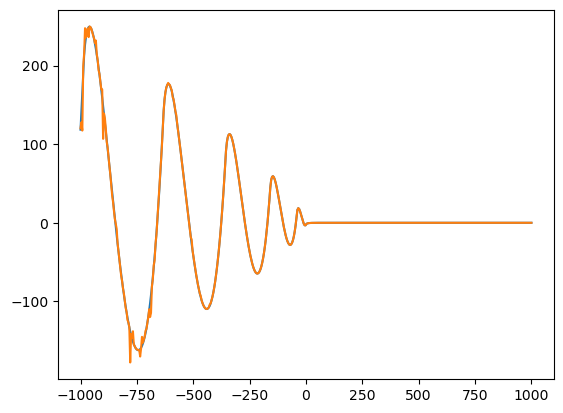

In [64]:
x_list = np.linspace(-1000,1000, 500)
Jblist = Jb(x_list)
Jbelist = Jbe(x_list)
plt.plot(x_list,Jblist)
plt.plot(x_list,Jbelist)

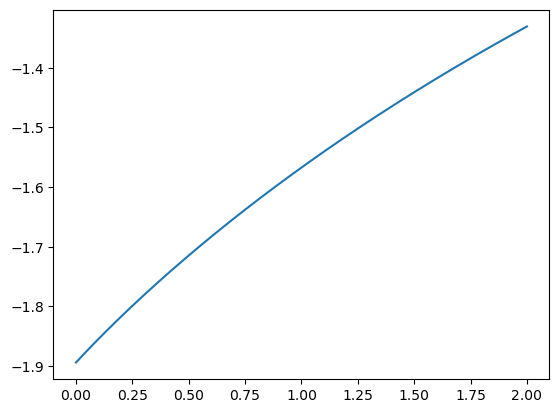

In [230]:
x_list = np.linspace(0,2,300)
y_list = Jf(x_list)
plt.plot(x_list,y_list)

In [48]:
class model_ALP(gp.generic_potential):
    """
    Class of CosmoTransitions. Input parameters are the 1-loop renormalized
    parameters (but not the directly-observed quantites such as mixing angle or mass).

    Parameters include:
    lh: Higgs quartic coupling.
    A: Higgs-ALP coupling.
    muHsq: Higgs mass term squared.
    muSsq: ALP mass term squared.
    f: scale parameter for the ALP, i.e. the "decay constant" of the axion. Could
    be understood as the UV-completion scale.
    beta: phase difference between the ALP mass term and the Higgs-ALP interaction term.

    Effective potential of the model, and some defined functions for computation.
    """

    def init(self, mS, sintheta, lh, A, muHsq, muSsq, f, beta):
        self.Ndim = 2
        self.g1 = g1
        self.g2 = g2
        self.yt = yt
        self.mS = mS
        self.sintheta = sintheta
        self.lh = lh
        self.A = A
        self.muHsq = muHsq
        self.muSsq = muSsq
        self.f = f
        self.beta = beta
        self.Tmax = 200
        self.renormScaleSq = mZEW**2
        self.Tc = None
        self.action_trace_data = None
        self.Tn = None

    def V0(self, X):
        """Tree-level potential."""

        # Define field variable quantities
        X = np.asanyarray(X)
        assert X.shape[-1] == 2

        h = X[..., 0]
        S = X[..., 1]

        # tree-level potential
        y_h = (
            -0.5 * (self.muHsq - self.A * self.f * np.sin(self.beta)) * h**2
            + 0.25 * self.lh * h**4
        )
        y_S = -self.f**2 * self.muSsq * (np.cos(S / self.f) - 1)
        y_hS = (
            -0.5 * self.A * self.f * (h**2 - 2 * v2) * np.sin(self.beta + S / self.f)
        )
        tot = y_h + y_S + y_hS

        return tot

    def boson_massSq(self, X, T):
        """
        Method of CosmoTransitions. Returns bosons mass square, dof and constants. The scalar masses are the eigenvalues of the full physical scalar matrix, plus the Nambu-Goldstone bosons.
        """

        X = np.array(X)
        T = np.asanyarray(T, dtype=float)
        T2 = T * T
        assert X.shape[-1] == 2
        h = X[..., 0]
        S = X[..., 1]

        mgs = (
            self.lh * h**2
            - self.muHsq
            - self.A * self.f * np.sin(S / self.f + self.beta)
            + self.A * self.f * np.sin(self.beta)
        ) + (
            3 * self.g2**2 / 16
            + self.g1**2 / 16
            + 0.5 * self.lh
            + 0.25 * self.yt**2
        ) * T2

        # Scalar mass matrix ((a,c),(c,b))
        aterm = (
            3 * self.lh * h**2
            - self.muHsq
            - self.A * self.f * np.sin(S / self.f + self.beta)
            + self.A * self.f * np.sin(self.beta)
        ) + (
            3 * self.g2**2 / 16
            + self.g1**2 / 16
            + 0.5 * self.lh
            + 0.25 * self.yt**2
        ) * T2

        cterm = -self.A * h * np.cos(S / self.f + self.beta)

        bterm = 0.5 * (
            self.A * (h**2 - 2 * v2) * np.sin(self.beta + S / self.f)
        ) / self.f + self.muSsq * np.cos(S / self.f)

        # Scalar eigenvalues
        mhsq = 0.5 * (aterm + bterm + np.sqrt((aterm - bterm) ** 2 + 4 * cterm**2))
        mSsq = 0.5 * (aterm + bterm - np.sqrt((aterm - bterm) ** 2 + 4 * cterm**2))

        mW = 0.25 * self.g2**2 * h**2
        mWL = mW + 11 * self.g2**2 * T2 / 6
        mZ = 0.25 * (self.g2**2 + self.g1**2) * h**2

        AZsq = np.sqrt(
            (self.g2**2 + self.g1**2) ** 2 * (3 * h**2 + 22 * T2) ** 2
            - 176 * self.g2**2 * self.g1**2 * T2 * (3 * h**2 + 11 * T2)
        )

        mZL = ((self.g2**2 + self.g1**2) * (3 * h**2 + 22 * T2) + AZsq) / 24
        mAL = ((self.g2**2 + self.g1**2) * (3 * h**2 + 22 * T2) - AZsq) / 24

        M = np.array([mSsq, mhsq, mgs, mW, mWL, mZ, mZL, mAL])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1, 1, 3, 4, 2, 2, 1, 1])
        c = np.array([1.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5])

        return M.real + 1e-16, dof, c

    def fermion_massSq(self, X):
        """
        Method of CosmoTransitions. Fermion mass square. Only top quark is included.
        """

        X = np.array(X)
        h = X[..., 0]

        mt = 0.5 * self.yt**2 * h**2
        Mf = np.array([mt])
        Mf = np.rollaxis(Mf, 0, len(Mf.shape))

        doff = np.array([12.0])

        return Mf, doff

    def V1(self, bosons, fermions, scale=mZEW):
        """
        Method of CosmoTransitions. Overwritten.

        The 1-loop CW correction at the zero-temperature in the
        MS-bar renormalization scheme.
        """

        scale2 = scale**2
        m2, n, c = bosons
        y = np.sum(n * m2 * m2 * (np.log(m2 / scale2 + 1e-100 + 0j) - c), axis=-1)
        m2, n = fermions
        c = 1.5
        y -= np.sum(n * m2 * m2 * (np.log(m2 / scale2 + 1e-100 + 0j) - c), axis=-1)
        return y.real / (64 * np.pi * np.pi)

    def V0T(self, X):
        """
        1-loop corrected effective potential at T=0.
        Not an intrinsic method of CosmoTransitions.
        """
        X = np.asanyarray(X, dtype=float)

        bosons = self.boson_massSq(X, 0)
        fermions = self.fermion_massSq(X)

        y = self.V0(X)
        y += self.V1(bosons, fermions)

        return y

    def V1T(self, bosons, fermions, T, include_radiation=True):
        """
        Method of CosmoTransitions. Should be overwritten.
        The 1-loop finite-temperature correction term.

        `Jf` and `Jb` are modified functions.

        TODO: understand this again, write note, and implement it.
        """

        T2 = (T * T) + 1e-100
        T4 = T2 * T2

        m2, nb, _ = bosons
        y = np.sum(nb * Jb(m2 / T2), axis=-1)
        m2, nf = fermions
        y += np.sum(nf * Jf(m2 / T2), axis=-1)

        return y * T4 / (2 * np.pi * np.pi)

    def Vtot(self, X, T, include_radiation=True):
        """
        Method of CosmoTransitions.
        The total finite temperature effective potential.
        """

        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        assert X.shape[-1] == 2

        bosons = self.boson_massSq(X, T)
        fermions = self.fermion_massSq(X)
        Vtot = self.V0(X)
        Vtot += self.V1(bosons, fermions)
        Vtot += self.V1T(bosons, fermions, T, include_radiation)

        return Vtot

    """
    So far we have computed the finite temperature effective potential.
    Move on to compute the relevant quantities in during the phase transition.
    """

    def approxZeroTMin(self):
        """
        There are generically two minima at zero temperature in this model,
        and we want to include both of them.
        """
        return [np.array([v, 0]), np.array([-v, 0])]

    def getTc(self):
        """
        Find the critical temperature, using the built-in `getPhases` function
        of cosmoTransitions.
        """
        if self.Tc is None:
            self.calcTcTrans()
        self.Tc = self.TcTrans[0]["Tcrit"]

    def true_vev(self, T):
        if self.phases is None:
            self.getPhases()
        true_vev_index = 0
        for i in self.phases:
            if self.phases[i].X[0][0] > 200:
                true_vev_index = i
        true_vev_h = self.phases[true_vev_index].X[..., 0]
        true_vev_S = self.phases[true_vev_index].X[..., 1]
        true_vev_T = self.phases[true_vev_index].T
        hfunc = interpolate.interp1d(true_vev_T, true_vev_h, kind="cubic")
        Sfunc = interpolate.interp1d(true_vev_T, true_vev_S, kind="cubic")
        return np.array([hfunc(T), Sfunc(T)])

    def false_vev(self, T):
        if self.phases is None:
            self.getPhases()
        false_vev_index = 0
        for i in self.phases:
            if self.phases[i].X[0][0] < 1:
                false_vev_index = i
        false_vev_h = self.phases[false_vev_index].X[..., 0]
        false_vev_S = self.phases[false_vev_index].X[..., 1]
        false_vev_T = self.phases[false_vev_index].T
        hfunc = interpolate.interp1d(false_vev_T, false_vev_h, kind="cubic")
        Sfunc = interpolate.interp1d(false_vev_T, false_vev_S, kind="cubic")
        return np.array([hfunc(T), Sfunc(T)])

    def tunneling_at_T(self, T):
        """
        Solve the bounce equation for the transition from the false vacuum
        to the true vacuum, at a given temperature T.
        Called the function `pathDeformation.fullTunneling()`
        in CosmoTransitions.
        Returns the bounce solution, including the bubble profile
        and the action.
        """

        if self.Tc is None:
            self.getTc()

        assert T < self.Tc

        def V_(x, T=T, V=self.Vtot):
            return V(x, T)

        def dV_(x, T=T, dV=self.gradV):
            return dV(x, T)

        false_vev = self.TcTrans[0]["high_vev"].tolist()
        true_vev = self.TcTrans[0]["low_vev"].tolist()

        tobj = pd.fullTunneling([true_vev, false_vev], V_, dV_)

        return tobj

    def S_over_T_sol(self, T):
        """
        The S_3/T at a given temperature T.
        Directly call the function to solve the bounce equation to get it.
        """
        Tv = T
        ST = self.tunneling_at_T(T=Tv).action / Tv
        return ST

    def trace_action(self):
        """
        Trace the evolution of the 3d Euclidean action S_3/T as temperature
        cooling down.
        Stores in self.action_trace_data.
        """
        if self.TcTrans == None:
            self.getTc()
        if self.mS <= 1:
            Tmax = self.Tc - 0.02
        elif self.mS <= 0.05:
            Tmax = self.Tc - 0.05
        else:
            Tmax = self.Tc - 0.01
        eps = 0.002
        list = []
        for i in range(0, 1000):
            Ttest = Tmax - i * eps
            print("Tunneling at T=" + str(Ttest))
            trigger = self.S_over_T_sol(Ttest)
            print("S3/T = " + str(trigger))
            list.append([Ttest, trigger])
            if trigger < 140.0:
                break
        Tmin = Ttest
        print("Tnuc should be within " + str(Tmin) + " and " + str(Tmin + eps))
        self.action_trace_data = np.array(list).transpose().tolist()

    def S_over_T_smooth(self, T):
        """
        The 3d Euclidean action at a given temperature T.
        Interpolated from the traced data.
        """
        if self.action_trace_data is None:
            print("No data to be used for interpolation. Tracing data...")
            self.trace_action()
        Tlist = self.action_trace_data[0]
        log_action_list = [np.log10(i) for i in self.action_trace_data[1]]
        y = interpolate.interp1d(Tlist, log_action_list, kind="cubic")
        return 10 ** y(T)

    def find_Tn(self):
        if self.action_trace_data is None:
            print("Tracing action data...")
            self.trace_action()

        def trigger(T):
            return np.log10(self.S_over_T_smooth(T)) - np.log10(140.0)

        self.Tn = optimize.brentq(
            trigger,
            self.action_trace_data[0][-2],
            self.action_trace_data[0][-1],
            disp=False,
            xtol=1e-5,
            rtol=1e-6,
        )
        print("Tnuc = " + str(self.Tn))

    def strength_Tn(self):
        if not self.Tn:
            self.findTn()
        Tnuc = self.Tn
        truevev_h = self.true_vev(Tnuc)[0]
        return truevev_h / Tnuc

    def beta_over_H(self):
        """
        Compute the \beta/H quantity at Tn,
        defined as Tn * (d(S_3/T)/dT).
        Use Ridders algorithm.
        """
        if self.Tn is None:
            self.find_Tn()
        Tnuc = self.Tn
        if self.action_trace_data is None:
            self.trace_action()
        eps = 0.5 * (Tnuc - self.action_trace_data[0][-1]) * 0.9
        dev = (
            self.S_over_T_smooth(Tnuc - 2.0 * eps)
            - 8.0 * self.S_over_T_smooth(Tnuc - eps)
            + 8.0 * self.S_over_T_smooth(Tnuc + eps)
            - self.S_over_T_smooth(Tnuc + 2.0 * eps)
        ) / (12.0 * eps)
        return dev * Tnuc

    def alpha(self):
        """
        Compute the \alpha quantity at Tn.
        """
        if not self.Tn:
            self.find_Tn()
        Tnuc = self.Tn
        if self.Tc - Tnuc >= 0.002:
            eps = 0.001
        else:
            eps = 0.0001

        def deltaV(T):
            falsev = self.false_vev(T)
            truev = self.true_vev(T)
            return self.Vtot(falsev, T) - self.Vtot(truev, T)

        dev = (
            deltaV(Tnuc - 2 * eps)
            - 8.0 * deltaV(Tnuc - eps)
            + 8.0 * deltaV(Tnuc + eps)
            - deltaV(Tnuc + 2.0 * eps)
        ) / (
            12.0 * eps
        )  # derivative of deltaV w.r.t T at Tn
        latent = deltaV(Tnuc) - 0.25 * Tnuc * dev
        rho_crit = np.pi**2 * 106.75 * Tnuc**4 / 30.0
        return latent / rho_crit

    """
    So far we finished computing everything.
    But for comparison, we need to compute the `1d` phase
    transition quantities.
    """


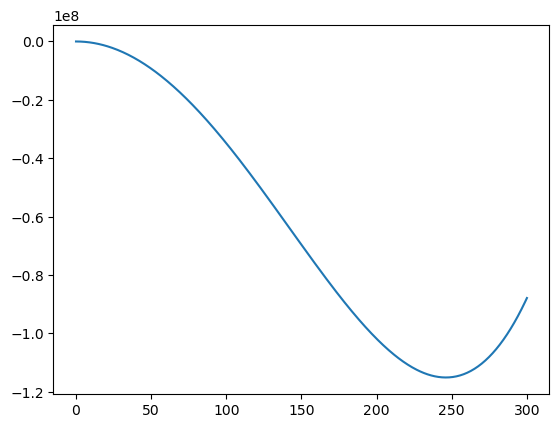

In [49]:
model = model_ALP(5, 0.17, 0.125559, 11.1902, 7602.87, 21.8353**2, 1e5, np.pi/10)
h_list = np.linspace(0,300,500)
y_list_tree = [model.V0([i,0])-model.V0([1e-16,0]) for i in h_list]
plt.plot(h_list, y_list_tree)
# test tree-level

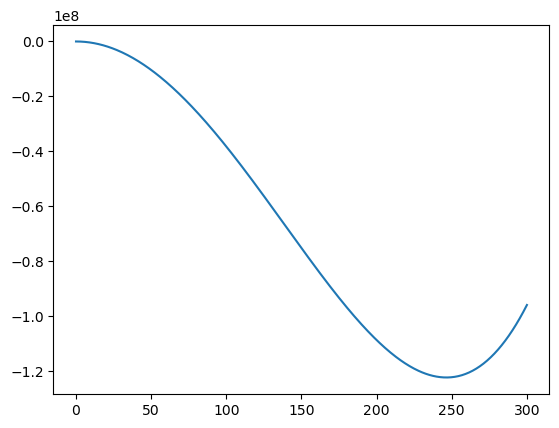

In [50]:
model = model_ALP(5, 0.17, 0.146672, 11.1836, 8607.8, 476.78, 1e5, np.pi/10)
h_list = np.linspace(0,300,500)
y_list = [model.V0T([i,0])-model.V0T([0,0]) for i in h_list]
plt.plot(h_list, y_list)
# test 1-loop level

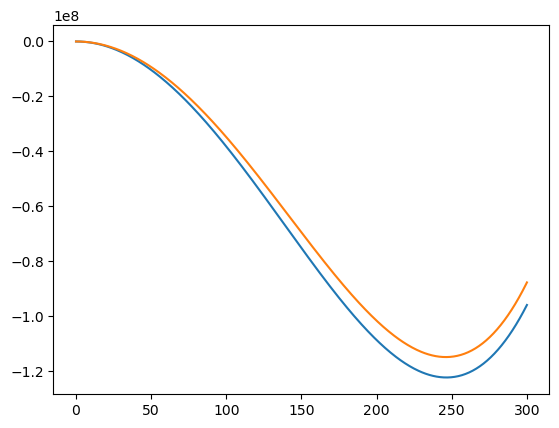

In [51]:
plt.plot(h_list, y_list)
plt.plot(h_list, y_list_tree)

In [52]:
model = model_ALP(5, 0.16, 0.14749514745168907, 10.61953003921521, 8643.793322995569, 428.1718668797098, 1e5, np.pi/10)

In [53]:
model.getTc()

Tracing phase starting at x = [-244.72044484   -9.24339994] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [54]:
np.array(model.true_vev(60))

array([ 151.93000448, -436.02547621])

In [17]:
model.trace_action()

Tunneling at T=65.4527573048669
Path deformation converged. 32 steps. fRatio = 1.90560e-02
Path deformation converged. 20 steps. fRatio = 1.69973e-02
Path deformation converged. 1 steps. fRatio = 4.30983e-02
S3/T = 36102.50135789598
Tunneling at T=65.45075730486691
Path deformation converged. 33 steps. fRatio = 1.99981e-02
Path deformation converged. 21 steps. fRatio = 1.96177e-02
Path deformation converged. 1 steps. fRatio = 4.75341e-02
S3/T = 25456.261687774804
Tunneling at T=65.4487573048669
Path deformation converged. 34 steps. fRatio = 1.38211e-02
Path deformation converged. 17 steps. fRatio = 1.35858e-02
Path deformation converged. 1 steps. fRatio = 3.94842e-02
S3/T = 18985.43651657003
Tunneling at T=65.4467573048669
Path deformation converged. 33 steps. fRatio = 1.64643e-02
Path deformation converged. 23 steps. fRatio = 1.95812e-02
Path deformation converged. 1 steps. fRatio = 4.83861e-02
S3/T = 14752.12783458938
Tunneling at T=65.44475730486691
Path deformation converged. 30 st

In [18]:
model.find_Tn()

In [19]:
model.Tn

65.24749554262988

In [20]:
model.strength_Tn()

1.1156046932386652

In [21]:
model.beta_over_H()

87964.35675188269

In [22]:
model.alpha()

0.0027451904903771653

## Comparison of interpolation methods

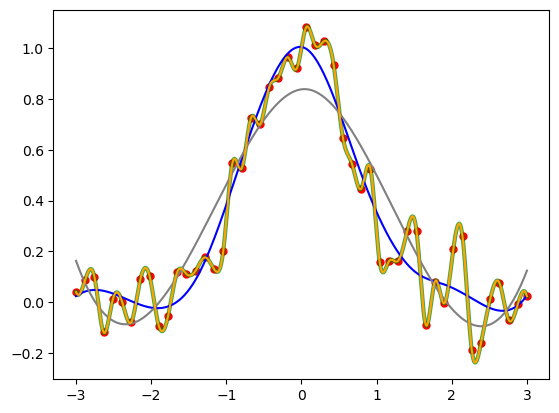

In [9]:
rng = np.random.default_rng()

x = np.linspace(-3, 3, 50)

y = np.exp(-x**2) + 0.1 * rng.standard_normal(50)

spl = InterpolatedUnivariateSpline(x, y)
smooth1 = UnivariateSpline(x,y, s=0.5)
smooth2 = UnivariateSpline(x,y, s=1.0)
int1d = interp1d(x,y, 'cubic')

plt.plot(x, y, 'ro', ms=5)

xs = np.linspace(-3, 3, 1000)

plt.plot(xs, spl(xs), 'g', lw=3, alpha=0.7)
plt.plot(xs, smooth1(xs), 'b')
plt.plot(xs, smooth2(xs), 'gray')
plt.plot(xs, int1d(xs), 'orange')

plt.show()

In [31]:
model.findMinimum(X=np.array([v*2**0.5, 0]),T=0)

array([244.72072006,  -9.24133166])